In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('input_csvs/cDNA_dilution_primer_test.csv')
df['log2_dilution'] = np.log2(df['fold_dilution'])
df

,fold_dilution,primer,CT,replicate,log2_dilution
0,1,short1,24.33,1,0.0
1,2,short1,25.41,1,1.0
2,4,short1,26.44,1,2.0
3,8,short1,28.02,1,3.0
4,16,short1,29.15,1,4.0
...,...,...,...,...,...
91,8,long2,24.42,2,3.0
92,16,long2,25.81,2,4.0
93,32,long2,26.53,2,5.0
94,64,long2,27.48,2,6.0


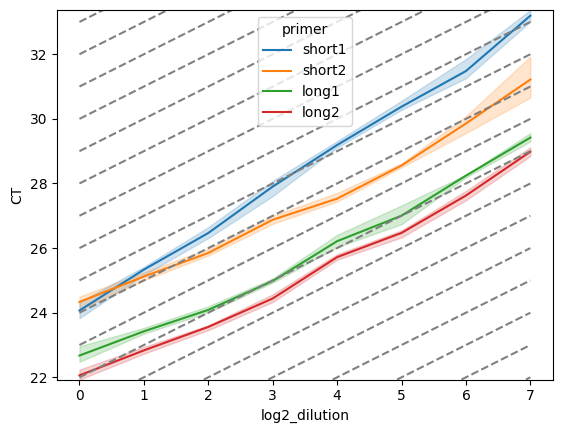

In [3]:
#
sns.lineplot(
    x = 'log2_dilution',
    y = 'CT',
    hue = 'primer',
    data = df,
)
y_min = df['CT'].min()
y_max = df['CT'].max()

#Make a background of y=x lines (which are 100's efficiency)
dashed_ymins = range(14,35)
for dashed_ymin in dashed_ymins:
    plt.plot((0,7),(dashed_ymin,dashed_ymin+7),color='grey',linestyle='dashed')
    
plt.ylim((y_min,y_max))
plt.show()
plt.close()

In [4]:
#Find the slope then efficiency for each primer
#Converting from slope of log2-diultion vs. CT to efficiency
#intuitively slope of 1 means perfect efficiency since a halving in sample creates an increase of 1 in CT
#slopes > 1 mean less than perfect efficiency since halving the sample results in MORE than a 1 CT increase
#for example, a slope of 2 would mean that halving the sample resulted in a 2 CT increase which is 50% efficiency
#similarly, a slope of 3 would mean that halving the sample resulted in a 3 CT increase which is 25% efficiency

#from this intuition, the equation for efficiency from slope is:
#efficiency = 100*(1/(2^(slope-1)))

#consider different ranges of dilutions to see if this changes the efficiencies much
#(it can change the efficiencies, but the conclusion of 'short1' being inefficient is the same)
dil_ranges = [
    {0,1,2,3,4,5,6,7},
    {0,1,2,3,4,5,6},
    {0,1,2,3,4,5},
    {0,1,2,3,4},
    {0,1,2,3},
    {0,1,2},
    {1,2,3,4,5,6,7},
    {1,2,3,4,5,6},
    {1,2,3,4,5},
    {1,2,3,4},
    {1,2,3},
]

eff_df = pd.DataFrame()
slope_df = pd.DataFrame()
interc_df = pd.DataFrame()

for dil_range in dil_ranges:

    reg_df = df[
        df['log2_dilution'].isin(dil_range)
    ].groupby('primer').apply(lambda g: np.polyfit(g.log2_dilution, g.CT, 1)).reset_index()
    
    reg_df[[f'{dil_range}_slope',f'{dil_range}_interc']] = reg_df[0].values.tolist()
    reg_df = reg_df.set_index('primer')
    reg_df[f'{dil_range}_efficiency'] = 100/(2**(reg_df[f'{dil_range}_slope']-1))
    
    eff_df = pd.concat((eff_df,reg_df[[f'{dil_range}_efficiency']]),axis=1)
    slope_df = pd.concat((slope_df,reg_df[[f'{dil_range}_slope']]),axis=1)
    interc_df = pd.concat((interc_df,reg_df[[f'{dil_range}_interc']]),axis=1)
    
print('Excluding different dilutions still results in similar primer efficiencies')
display(eff_df.T)

print('Using {1, 2, 3, 4, 5, 6, 7}_efficiency since the values are closest to 100 for l1/l2/s2')
efficiencies = eff_df['{1, 2, 3, 4, 5, 6, 7}_efficiency']
slopes = slope_df['{1, 2, 3, 4, 5, 6, 7}_slope']
intercs = interc_df['{1, 2, 3, 4, 5, 6, 7}_interc']

efficiencies

Excluding different dilutions still results in similar primer efficiencies


primer,long1,long2,short1,short2
"{0, 1, 2, 3, 4, 5, 6, 7}_efficiency",102.244540,101.295594,82.279852,102.811383
"{0, 1, 2, 3, 4, 5, 6}_efficiency",105.084335,104.729412,83.985623,107.380952
"{0, 1, 2, 3, 4, 5}_efficiency",108.429845,106.986486,82.756950,111.787735
"{0, 1, 2, 3, 4}_efficiency",109.910814,107.723524,82.264012,113.681697
"{0, 1, 2, 3}_efficiency",118.235779,115.936379,83.258338,112.038921
"{0, 1, 2}_efficiency",122.546844,118.920712,87.055056,118.235779
"{1, 2, 3, 4, 5, 6, 7}_efficiency",99.194589,98.493146,81.871235,100.041267
"{1, 2, 3, 4, 5, 6}_efficiency",101.831964,102.047306,84.089642,105.165877
"{1, 2, 3, 4, 5}_efficiency",105.068728,104.005993,82.302035,110.547520
"{1, 2, 3, 4}_efficiency",105.238797,103.239854,81.187714,112.844283


Using {1, 2, 3, 4, 5, 6, 7}_efficiency since the values are closest to 100 for l1/l2/s2


primer
long1      99.194589
long2      98.493146
short1     81.871235
short2    100.041267
Name: {1, 2, 3, 4, 5, 6, 7}_efficiency, dtype: float64

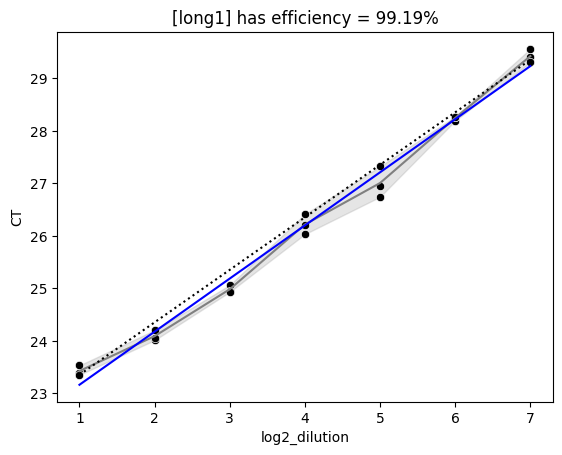

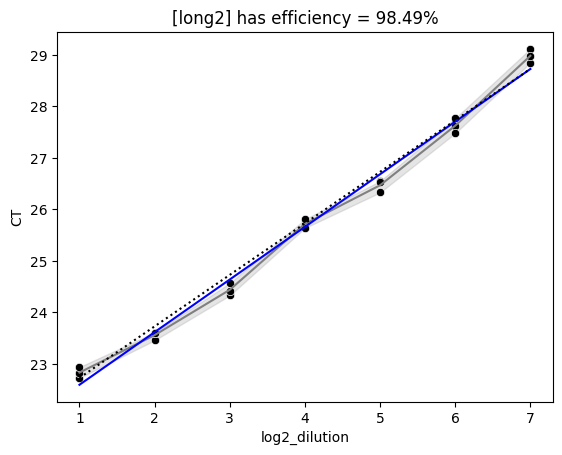

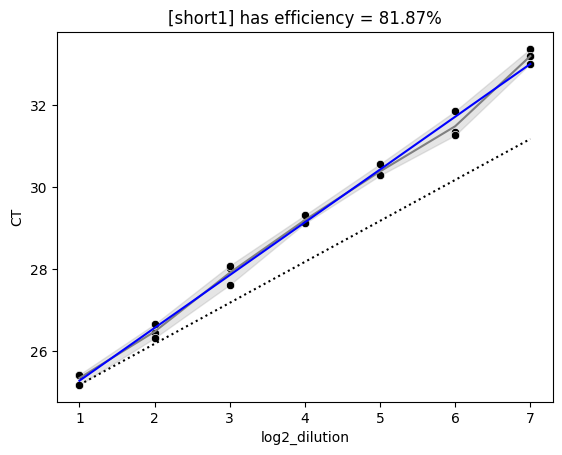

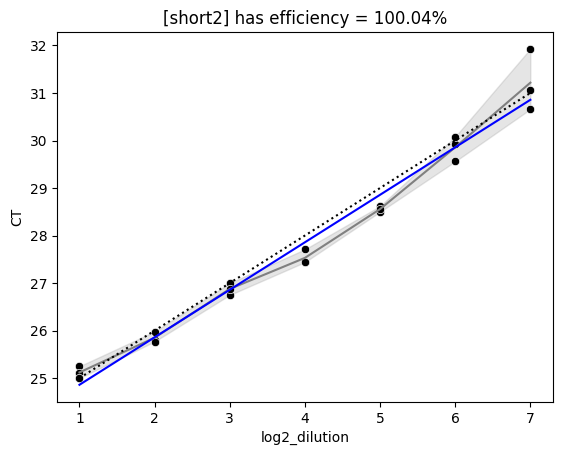

In [5]:
for primer,plot_df in df.groupby('primer'):
    plot_df = plot_df[plot_df['log2_dilution'].isin({1,2,3,4,5,6,7})]
    
    sns.lineplot(
        x = 'log2_dilution',
        y = 'CT',
        color = 'grey',
        data = plot_df,
    )
    sns.scatterplot(
        x = 'log2_dilution',
        y = 'CT',
        color = 'black',
        data = plot_df,
    )
    
    min_x = plot_df['log2_dilution'].min()
    min_y = plot_df['CT'].min()
    max_x = plot_df['log2_dilution'].max()
    max_lin_y = min_y+(max_x-min_x)

    
    efficiency = efficiencies.loc[primer]
    slope = slopes.loc[primer]
    interc = intercs.loc[primer]
    
    plt.plot([min_x,max_x],[interc+slope*min_x,interc+slope*max_x], color='blue') #best fit line
    plt.plot([min_x,max_x],[min_y,max_lin_y], color='black', linestyle='dotted') #y = x
    
    
    plt.title(f'[{primer}] has efficiency = {efficiency:.2f}%')
#     plt.text(
#         min_x-0.5,
#         max_lin_y-1,
#         '''
#         Blue line is the line of best fit
#         Dotted line is 100% efficiency (2-fold dil --> +1 CT)
#         If Blue is below dotted line: Efficiency > 100% (2-fold dil --> < +1 CT)
#         If Blue is above dotted line: Efficiency < 100% (2-fold dil --> > +1 CT)
#         ''',
#         fontsize=8,
#     )
    plt.show()
    plt.close()
    
    

In [6]:
#(sanity checking)
#Making sure that averaging the technical replicates before regression leads to the same slopes
mean_df = df.groupby(['primer','log2_dilution']).agg(
    mean_CT = ('CT','mean'),
).reset_index()

display(mean_df.head())

mean_df.groupby('primer').apply(lambda g: np.polyfit(g.log2_dilution, g.mean_CT, 1)).reset_index()

,primer,log2_dilution,mean_CT
0,long1,0.0,22.673333
1,long1,1.0,23.423333
2,long1,2.0,24.086667
3,long1,3.0,24.980000
4,long1,4.0,26.213333


,primer,0
0,long1,"[0.9679761904761891, 22.367499999999996]"
1,long2,"[0.9814285714285694, 21.77666666666666]"
2,short1,"[1.281388888888888, 24.016388888888887]"
3,short2,"[0.9599999999999996, 24.0575]"


In [7]:
#A slope of 1 indicates an increase of 1-CT for each sample halving, which would be perfect efficiency

#A slope > 1 indicates an increase of MORE than 1-CT for a halving, which indicates imperfect efficiency

#A slope < 1 indicates an increase of less than 1-CT for a halving, which indicates "super-perfect" efficiency
#(doesn't look like this is really occuring which is good)